In [1]:
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
urls = {
    '0.00' : '../data/model_out/InflowModel_00_s2f_true.csv',
    '0.25' : '../data/model_out/InflowModel_25_s2f_true.csv',
    '0.50' : '../data/model_out/InflowModel_50_s2f_true.csv',
    '0.75' : '../data/model_out/InflowModel_75_s2f_true.csv',
}

flow_dct = dict()
dlt_dct = dict()
vlt_dct = dict()
hll_dct = dict()
aac_dct = dict()
count = list(['0.00', '0.25', '0.50', '0.75'])

for number in count:
    flow_dct[number] = pd.read_csv(urls[number])
    flow_dct[number] = flow_dct[number].add_suffix('r')
    flow_dct[number] = flow_dct[number].add_prefix('_')
    flow_dct[number] = flow_dct[number].apply(pd.to_numeric, errors = 'coerce')

    dlt_dct[number] = flow_dct[number].filter(regex='Deltas_', axis=1)
    dlt_dct[number].dropna(inplace=True)
    dlt_dct[number][number] = dlt_dct[number].mean(axis=1)   
    dlt_dct[number] = dlt_dct[number].iloc[:,-1:]

    vlt_dct[number] = flow_dct[number].filter(regex='Volatility_', axis=1)
    vlt_dct[number].dropna(inplace=True)
    vlt_dct[number][number] = vlt_dct[number].mean(axis=1)   
    vlt_dct[number] = vlt_dct[number].iloc[:,-1:]

    hll_dct[number] = flow_dct[number].filter(regex='_hillIdx_', axis=1)
    hll_dct[number].dropna(inplace=True)
    hll_dct[number][number] = hll_dct[number].mean(axis=1)   
    hll_dct[number] = hll_dct[number].iloc[:,-1:]

    aac_dct[number] = flow_dct[number].filter(regex='_AACFr_', axis=1)
    aac_dct[number].dropna(inplace=True)
    aac_dct[number][number] = aac_dct[number].mean(axis=1)   
    aac_dct[number] = aac_dct[number].iloc[:,-1:]

deltas = pd.concat(dlt_dct.values(), axis=1).T
deltas.columns = ['WAMS','Volatility','HillIDX','ACabsR']
deltas.set_index(pd.Index(count), inplace=True)

volas = pd.concat(vlt_dct.values(), axis=1).T
volas.columns = ['Vprice','Vreturn']
volas.set_index(pd.Index(count), inplace=True)

hlidxs = pd.concat(hll_dct.values(), axis=1).iloc[1:]
hlidxs.columns = count
hlidxs.set_index(pd.Index(flow_dct['0.00']['_hillObs_1r'].iloc[1:].dropna()), inplace=True)

aacs = pd.concat(aac_dct.values(), axis=1).iloc[1:]
aacs.columns = count


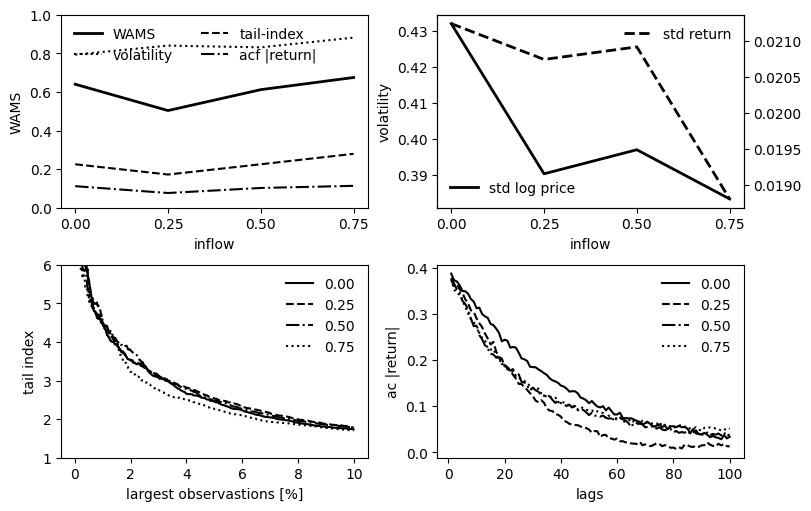

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(8,5))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:1 , 0:1])
wams = ax1.plot(deltas.WAMS, color='black', linewidth=2, label= 'WAMS')
volatility = ax1.plot(deltas.Volatility / (0.2125 * 3), color='black', linestyle='dotted', label='volatility')
tailidx = ax1.plot(deltas.HillIDX / (0.1674 * 3), color='black', linestyle='dashed', label='tail-index')
autocor = ax1.plot(deltas.ACabsR / (3.8845 * 3), color='black', linestyle='dashdot', label='acf |return|')
ax1.set_ylabel('WAMS')
ax1.set_xlabel('inflow')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', ncol=2, frameon=0)
ax1.set_ylim([0,1])

ax2 = fig.add_subplot(gs[0:1 , 1:2])
vPrice = ax2.plot(volas.Vprice, color='black', linewidth=2, label='std log price')
ax2.set_ylabel('volatility')
ax2.set_xlabel('inflow')
# ax2.set_ylim([0.65,0.75])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(labels, loc='lower left', frameon=0)
ax22 = ax2.twinx() 
vReturns = ax22.plot(volas.Vreturn, color='black', linewidth=2, linestyle='dashed', label='std return')
handles, labels = ax22.get_legend_handles_labels()
ax22.legend(labels, loc='upper right', frameon=0)
# ax22.set_ylim([0.039,0.042])

ax3 = fig.add_subplot(gs[1: , 0:1])
m5 = ax3.plot(hlidxs['0.00'], color='black', linewidth=1.5, label='0.00')
m2 = ax3.plot(hlidxs['0.25'], color='black', linewidth=1.5, linestyle='dashed', label='0.25')
m0 = ax3.plot(hlidxs['0.50'], color='black', linewidth=1.5, linestyle='dashdot', label='0.50')
p3 = ax3.plot(hlidxs['0.75'], color='black', linewidth=1.5, linestyle='dotted', label='0.75')
ax3.set_ylabel('tail index')
ax3.set_xlabel('largest observastions [%]')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper right', frameon=0)
ax3.set_ylim([1,6])

ax4 = fig.add_subplot(gs[1: , 1:2])
m5 = ax4.plot(aacs['0.00'], color='black', linewidth=1.5, label='0.00')
m2 = ax4.plot(aacs['0.25'], color='black', linewidth=1.5, linestyle='dashed', label='0.25')
m0 = ax4.plot(aacs['0.50'], color='black', linewidth=1.5, linestyle='dashdot', label='0.50')
p3 = ax4.plot(aacs['0.75'], color='black', linewidth=1.5, linestyle='dotted', label='0.75')
ax4.set_ylabel('ac |return|')
ax4.set_xlabel('lags')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, loc='upper right', frameon=0)

# plt.savefig(fname="Inflow-Impact-Unrestricted.svg", format="svg")
plt.show()

In [8]:
urls2 = {
    '0.00' : '../data/model_out/InflowModel_00_s2f_false.csv',
    '0.25' : '../data/model_out/InflowModel_25_s2f_false.csv',
    '0.50' : '../data/model_out/InflowModel_50_s2f_false.csv',
    '0.75' : '../data/model_out/InflowModel_75_s2f_false.csv',
}

flow_dct2 = dict()
dlt_dct2 = dict()
vlt_dct2 = dict()
hll_dct2 = dict()
aac_dct2 = dict()
count2 = list(['0.00', '0.25', '0.50', '0.75'])

for number in count2:
    flow_dct2[number] = pd.read_csv(urls2[number])
    flow_dct2[number] = flow_dct2[number].add_suffix('r')
    flow_dct2[number] = flow_dct2[number].add_prefix('_')
    flow_dct2[number] = flow_dct2[number].apply(pd.to_numeric, errors = 'coerce')

    dlt_dct2[number] = flow_dct2[number].filter(regex='Deltas_', axis=1)
    dlt_dct2[number].dropna(inplace=True)
    dlt_dct2[number][number] = dlt_dct2[number].mean(axis=1)   
    dlt_dct2[number] = dlt_dct2[number].iloc[:,-1:]

    vlt_dct2[number] = flow_dct2[number].filter(regex='Volatility_', axis=1)
    vlt_dct2[number].dropna(inplace=True)
    vlt_dct2[number][number] = vlt_dct2[number].mean(axis=1)   
    vlt_dct2[number] = vlt_dct2[number].iloc[:,-1:]

    hll_dct2[number] = flow_dct2[number].filter(regex='_hillIdx_', axis=1)
    hll_dct2[number].dropna(inplace=True)
    hll_dct2[number][number] = hll_dct2[number].mean(axis=1)   
    hll_dct2[number] = hll_dct2[number].iloc[:,-1:]

    aac_dct2[number] = flow_dct2[number].filter(regex='_AACFr_', axis=1)
    aac_dct2[number].dropna(inplace=True)
    aac_dct2[number][number] = aac_dct2[number].mean(axis=1)   
    aac_dct2[number] = aac_dct2[number].iloc[:,-1:]

deltas2 = pd.concat(dlt_dct2.values(), axis=1).T
deltas2.columns = ['WAMS','Volatility','HillIDX','ACabsR']
deltas2.set_index(pd.Index(count2), inplace=True)

volas2 = pd.concat(vlt_dct2.values(), axis=1).T
volas2.columns = ['Vprice','Vreturn']
volas2.set_index(pd.Index(count2), inplace=True)

hlidxs2 = pd.concat(hll_dct2.values(), axis=1).iloc[1:]
hlidxs2.columns = count2
hlidxs2.set_index(pd.Index(flow_dct2['0.00']['_hillObs_1r'].iloc[1:].dropna()), inplace=True)

aacs2 = pd.concat(aac_dct2.values(), axis=1).iloc[1:]
aacs2.columns = count2

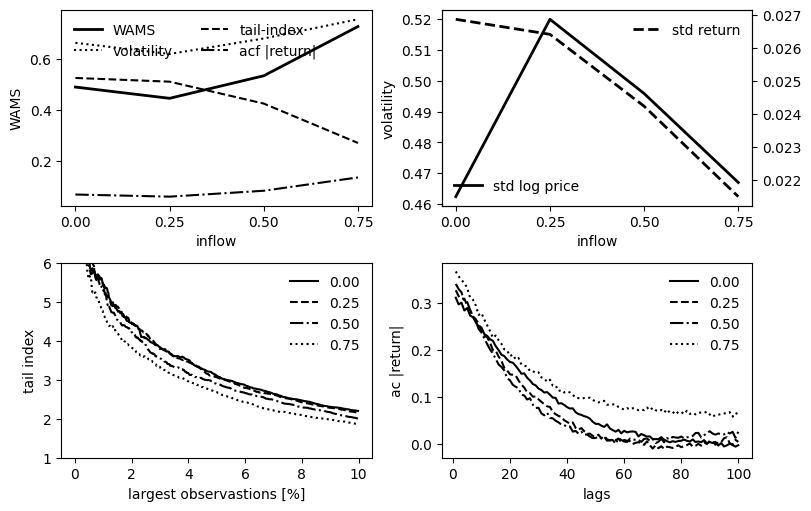

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(8,5))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:1 , 0:1])
wams = ax1.plot(deltas2.WAMS, color='black', linewidth=2, label= 'WAMS')
volatility = ax1.plot(deltas2.Volatility / (0.2125 * 3), color='black', linestyle='dotted', label='volatility')
tailidx = ax1.plot(deltas2.HillIDX / (0.1674 * 3), color='black', linestyle='dashed', label='tail-index')
autocor = ax1.plot(deltas2.ACabsR / (3.8845 * 3), color='black', linestyle='dashdot', label='acf |return|')
ax1.set_ylabel('WAMS')
ax1.set_xlabel('inflow')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', ncol=2, frameon=0)
# ax1.set_ylim([0,1.6])

ax2 = fig.add_subplot(gs[0:1 , 1:2])
vPrice = ax2.plot(volas2.Vprice, color='black', linewidth=2, label='std log price')
ax2.set_ylabel('volatility')
ax2.set_xlabel('inflow')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(labels, loc='lower left', frameon=0)
#ax2.set_ylim([1,1.12])
ax22 = ax2.twinx() 
vReturns = ax22.plot(volas2.Vreturn, color='black', linewidth=2, linestyle='dashed', label='std return')
handles, labels = ax22.get_legend_handles_labels()
ax22.legend(labels, loc='upper right', frameon=0)
#ax22.set_ylim([0.0475,0.051])

ax3 = fig.add_subplot(gs[1: , 0:1])
m5 = ax3.plot(hlidxs2['0.00'], color='black', linewidth=1.5, label='0.00')
m2 = ax3.plot(hlidxs2['0.25'], color='black', linewidth=1.5, linestyle='dashed', label='0.25')
m0 = ax3.plot(hlidxs2['0.50'], color='black', linewidth=1.5, linestyle='dashdot', label='0.50')
p3 = ax3.plot(hlidxs2['0.75'], color='black', linewidth=1.5, linestyle='dotted', label='0.75')
ax3.set_ylabel('tail index')
ax3.set_xlabel('largest observastions [%]')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper right', frameon=0)
ax3.set_ylim([1,6])

ax4 = fig.add_subplot(gs[1: , 1:2])
m5 = ax4.plot(aacs2['0.00'], color='black', linewidth=1.5, label='0.00')
m2 = ax4.plot(aacs2['0.25'], color='black', linewidth=1.5, linestyle='dashed', label='0.25')
m0 = ax4.plot(aacs2['0.50'], color='black', linewidth=1.5, linestyle='dashdot', label='0.50')
p3 = ax4.plot(aacs2['0.75'], color='black', linewidth=1.5, linestyle='dotted', label='0.75')
ax4.set_ylabel('ac |return|')
ax4.set_xlabel('lags')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, loc='upper right', frameon=0)

# plt.savefig(fname="Inlfow-Impact-Restricted.svg", format="svg")
plt.show()

In [11]:
delta_dct = dict()
mean_runs = dict()

for number in count:
    delta_dct[number] = flow_dct[number].filter(regex='Deltas_', axis=1)
    delta_dct[number]['Delta_mean'] = delta_dct[number].mean(axis=1)
    delta_dct[number]['Delta_median'] = delta_dct[number].median(axis=1)
    delta_dct[number].dropna(inplace=True)

    diff = abs(delta_dct[number].iloc[0, :-6] - delta_dct[number]['Delta_median'].iloc[0])

    mean_number = diff.idxmin().split('_')[2]
    mean_str = '_' + mean_number
    mean_runs[number] = flow_dct2[number].filter(regex=mean_str, axis=1)
    mean_runs[number].columns = mean_runs[number].columns.str.split('_').str.get(1)
    mean_runs[number]['MarketFlow'] =  mean_runs[number]['MarketCount'].diff().rolling(28).sum()


delta_dct2 = dict()
mean_runs2 = dict()

for number in count2:
    delta_dct2[number] = flow_dct2[number].filter(regex='Deltas_', axis=1)
    delta_dct2[number]['Delta_mean'] = delta_dct2[number].mean(axis=1)
    delta_dct2[number]['Delta_median'] = delta_dct2[number].median(axis=1)
    delta_dct2[number].dropna(inplace=True)

    diff = abs(delta_dct2[number].iloc[0, :-6] - delta_dct2[number]['Delta_median'].iloc[0])

    mean_number = diff.idxmin().split('_')[2]
    mean_str = '_' + mean_number
    mean_runs2[number] = flow_dct2[number].filter(regex=mean_str, axis=1)
    mean_runs2[number].columns = mean_runs2[number].columns.str.split('_').str.get(1)
    mean_runs2[number]['MarketFlow'] =  mean_runs2[number]['MarketCount'].diff().rolling(28).sum()

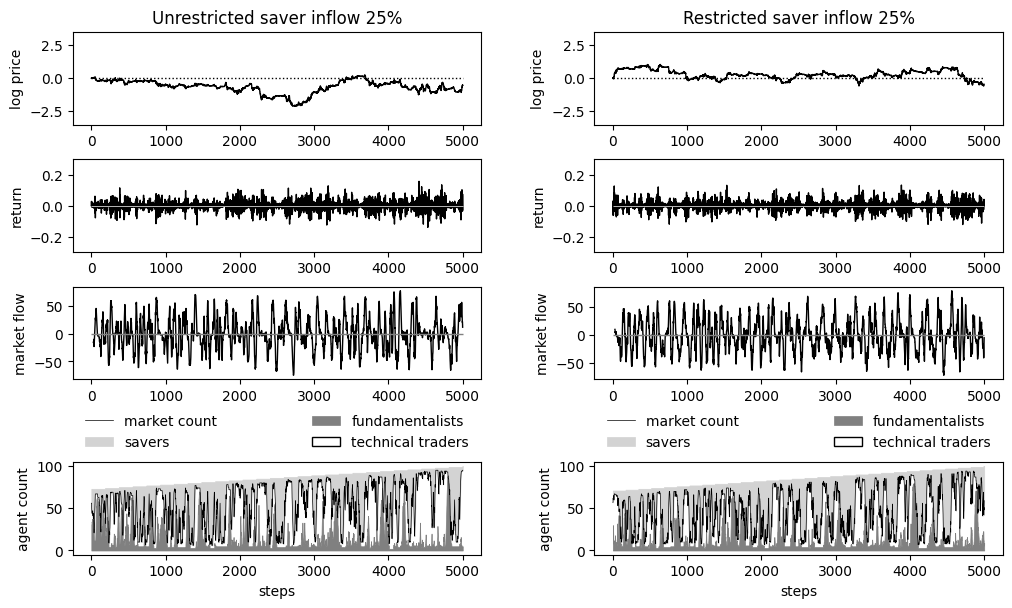

In [13]:
fig = plt.figure(figsize=(12,7))
gs = GridSpec(34, 18)

# MEAN Run 25% Inflow
ax1 = plt.subplot(gs[1:7, 0:8])
ax1.title.set_text('Unrestricted saver inflow 25%')
ax1.plot(mean_runs['0.25'].logPrice, color='black', linewidth=1)
ax1.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax1.set_ylabel('log price')
# element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
# ax1.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax1.set_ylim(-3.5,3.5)

ax2 = plt.subplot(gs[9:15, 0:8])
ax2.plot(mean_runs['0.25'].Returns, color='black', linewidth=1)
ax2.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax2.set_ylabel('return')
ax2.set_ylim(-0.3, 0.3)

ax3 = plt.subplot(gs[17:23, 0:8])
ax3.plot(mean_runs['0.25'].MarketFlow, color='black', linewidth=1)
ax3.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax3.set_ylabel('market flow')

ax4 = plt.subplot(gs[28:34, 0:8])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax4.plot(mean_runs['0.25'].MarketCount, color='black', linewidth=0.5, label='market count')
ax4.fill_between(mean_runs['0.25'].index, mean_runs['0.25'].MarketCount, mean_runs['0.25'].AgentCount, color='lightgrey', linewidth=.5, label='savers')
ax4.fill_between(mean_runs['0.25'].index, mean_runs['0.25'].FundCount, 0, color='grey', linewidth=.5, label='fundamentalists')
ax4.set_ylabel('agent count')
ax4.set_xlabel('steps')
lgd = ax4.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# MEAN Run 25% Inflow
ax13 = plt.subplot(gs[1:7, 10:18])
ax13.title.set_text('Restricted saver inflow 25%')
ax13.plot(mean_runs2['0.25'].logPrice, color='black', linewidth=1)
ax13.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax13.set_ylabel('log price')
# element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
# ax13.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax13.set_ylim(-3.5,3.5)

ax14 = plt.subplot(gs[9:15, 10:18])
ax14.plot(mean_runs2['0.25'].Returns, color='black', linewidth=1)
ax14.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax14.set_ylabel('return')
ax14.set_ylim(-0.3, 0.3)

ax15 = plt.subplot(gs[17:23, 10:18])
ax15.plot(mean_runs2['0.25'].MarketFlow, color='black', linewidth=1)
ax15.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax15.set_ylabel('market flow')

ax16 = plt.subplot(gs[28:34, 10:18])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax16.plot(mean_runs2['0.25'].MarketCount, color='black', linewidth=0.5, label='market count')
ax16.fill_between(mean_runs2['0.25'].index, mean_runs2['0.25'].MarketCount, mean_runs2['0.25'].AgentCount, linewidth=.5,color='lightgrey', label='savers')
ax16.fill_between(mean_runs2['0.25'].index, mean_runs2['0.25'].FundCount, 0, color='grey',linewidth=.5, label='fundamentalists')
ax16.set_ylabel('agent count')
ax16.set_xlabel('steps')
lgd = ax16.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.savefig(fname="savers-inflow-25.svg", format="svg")
plt.show()

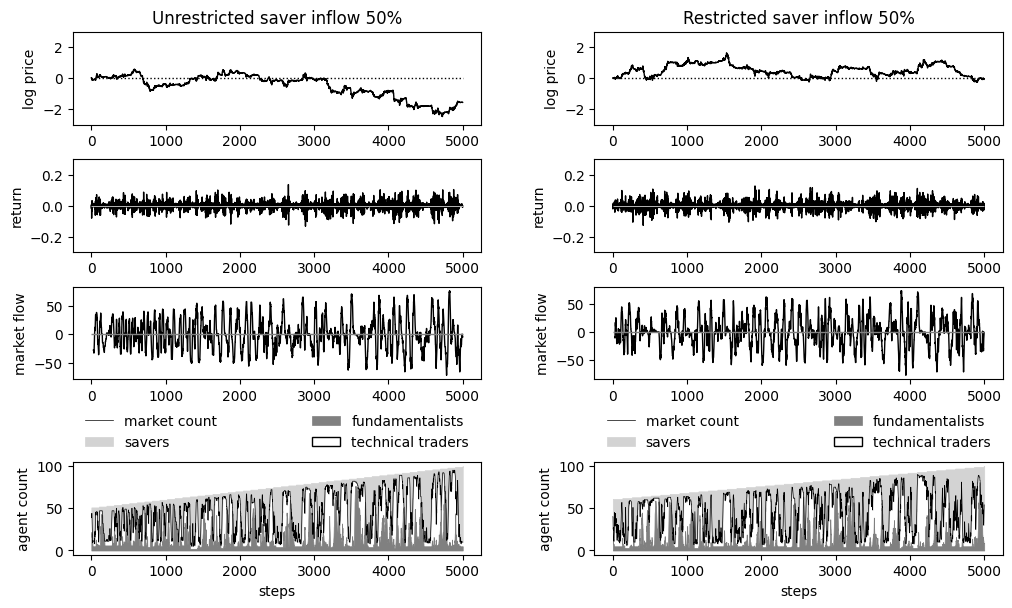

In [14]:
fig = plt.figure(figsize=(12,7))
gs = GridSpec(34, 18)

# MEAN Run 25% Inflow
ax1 = plt.subplot(gs[1:7, 0:8])
ax1.title.set_text('Unrestricted saver inflow 50%')
ax1.plot(mean_runs['0.50'].logPrice, color='black', linewidth=1)
ax1.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax1.set_ylabel('log price')
# element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
# ax1.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax1.set_ylim(-3,3)

ax2 = plt.subplot(gs[9:15, 0:8])
ax2.plot(mean_runs['0.50'].Returns, color='black', linewidth=1)
ax2.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax2.set_ylabel('return')
ax2.set_ylim(-0.3, 0.3)

ax3 = plt.subplot(gs[17:23, 0:8])
ax3.plot(mean_runs['0.50'].MarketFlow, color='black', linewidth=1)
ax3.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax3.set_ylabel('market flow')

ax4 = plt.subplot(gs[28:34, 0:8])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax4.plot(mean_runs['0.50'].MarketCount, color='black', linewidth=0.5, label='market count')
ax4.fill_between(mean_runs['0.50'].index, mean_runs['0.50'].MarketCount, mean_runs['0.50'].AgentCount, color='lightgrey', linewidth=.5, label='savers')
ax4.fill_between(mean_runs['0.50'].index, mean_runs['0.50'].FundCount, 0, color='grey', linewidth=.5, label='fundamentalists')
ax4.set_ylabel('agent count')
ax4.set_xlabel('steps')
lgd = ax4.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# MEAN Run 50% Inflow
ax13 = plt.subplot(gs[1:7, 10:18])
ax13.title.set_text('Restricted saver inflow 50%')
ax13.plot(mean_runs2['0.50'].logPrice, color='black', linewidth=1)
ax13.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax13.set_ylabel('log price')
# element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
# ax13.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax13.set_ylim(-3,3)

ax14 = plt.subplot(gs[9:15, 10:18])
ax14.plot(mean_runs2['0.50'].Returns, color='black', linewidth=1)
ax14.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax14.set_ylabel('return')
ax14.set_ylim(-0.3, 0.3)

ax15 = plt.subplot(gs[17:23, 10:18])
ax15.plot(mean_runs2['0.50'].MarketFlow, color='black', linewidth=1)
ax15.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax15.set_ylabel('market flow')

ax16 = plt.subplot(gs[28:34, 10:18])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax16.plot(mean_runs2['0.50'].MarketCount, color='black', linewidth=0.5, label='market count')
ax16.fill_between(mean_runs2['0.50'].index, mean_runs2['0.50'].MarketCount, mean_runs2['0.50'].AgentCount, linewidth=.5,color='lightgrey', label='savers')
ax16.fill_between(mean_runs2['0.50'].index, mean_runs2['0.50'].FundCount, 0, color='grey',linewidth=.5, label='fundamentalists')
ax16.set_ylabel('agent count')
ax16.set_xlabel('steps')
lgd = ax16.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.savefig(fname="savers-inflow-50.svg", format="svg")
plt.show()

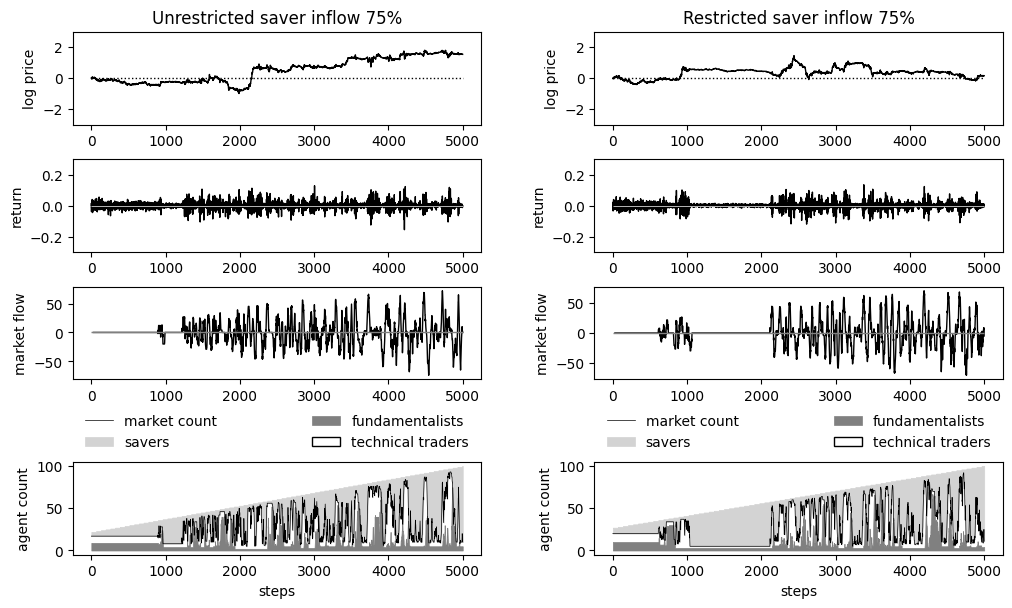

In [15]:
fig = plt.figure(figsize=(12,7))
gs = GridSpec(34, 18)

# MEAN Run 75% Inflow
ax1 = plt.subplot(gs[1:7, 0:8])
ax1.title.set_text('Unrestricted saver inflow 75%')
ax1.plot(mean_runs['0.75'].logPrice, color='black', linewidth=1)
ax1.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax1.set_ylabel('log price')
# element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
# ax1.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax1.set_ylim(-3,3)

ax2 = plt.subplot(gs[9:15, 0:8])
ax2.plot(mean_runs['0.75'].Returns, color='black', linewidth=1)
ax2.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax2.set_ylabel('return')
ax2.set_ylim(-0.3, 0.3)

ax3 = plt.subplot(gs[17:23, 0:8])
ax3.plot(mean_runs['0.75'].MarketFlow, color='black', linewidth=1)
ax3.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax3.set_ylabel('market flow')

ax4 = plt.subplot(gs[28:34, 0:8])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax4.plot(mean_runs['0.75'].MarketCount, color='black', linewidth=0.5, label='market count')
ax4.fill_between(mean_runs['0.75'].index, mean_runs['0.75'].MarketCount, mean_runs['0.75'].AgentCount, color='lightgrey', linewidth=.5, label='savers')
ax4.fill_between(mean_runs['0.75'].index, mean_runs['0.75'].FundCount, 0, color='grey', linewidth=.5, label='fundamentalists')
ax4.set_ylabel('agent count')
ax4.set_xlabel('steps')
lgd = ax4.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# MEAN Run 75% Inflow
ax13 = plt.subplot(gs[1:7, 10:18])
ax13.title.set_text('Restricted saver inflow 75%')
ax13.plot(mean_runs2['0.75'].logPrice, color='black', linewidth=1)
ax13.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax13.set_ylabel('log price')
# element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
# ax13.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax13.set_ylim(-3,3)

ax14 = plt.subplot(gs[9:15, 10:18])
ax14.plot(mean_runs2['0.75'].Returns, color='black', linewidth=1)
ax14.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax14.set_ylabel('return')
ax14.set_ylim(-0.3, 0.3)

ax15 = plt.subplot(gs[17:23, 10:18])
ax15.plot(mean_runs2['0.75'].MarketFlow, color='black', linewidth=1)
ax15.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax15.set_ylabel('market flow')

ax16 = plt.subplot(gs[28:34, 10:18])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax16.plot(mean_runs2['0.75'].MarketCount, color='black', linewidth=0.5, label='market count')
ax16.fill_between(mean_runs2['0.75'].index, mean_runs2['0.75'].MarketCount, mean_runs2['0.75'].AgentCount, linewidth=.5,color='lightgrey', label='savers')
ax16.fill_between(mean_runs2['0.75'].index, mean_runs2['0.75'].FundCount, 0, color='grey',linewidth=.5, label='fundamentalists')
ax16.set_ylabel('agent count')
ax16.set_xlabel('steps')
lgd = ax16.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.savefig(fname="savers-inflow-75.svg", format="svg")
plt.show()